In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as web
import graphviz
from Functions import *
import quandl
import datetime as dt

% matplotlib inline
Psize = (20,10)

In [7]:
"""
Define a function that does the following:

It takes in the historical prices to-date and outputs a buy, sell or hold signal.
"""

def simple_macd_strategy(today_close,his_close):
    
    all_close = np.append(his_close.values,[today_close])
    # Calculate MACD signals
    macd_signal = get_macd_signal(all_close)
    macd = macd_signal['macd']
    signal = macd_signal['signal']
    
    # Get buy or sell signal
    i_max = len(all_close) - 1
    if ((macd[i_max-1] < signal[i_max-1]) & (macd[i_max] > signal[i_max])):
        action = 'buy'
    elif ((macd[i_max-1] > signal[i_max-1]) & (macd[i_max] < signal[i_max])):
        action = 'sell'
    else:
        action = 'hold'
        
    return action

simple_macd_strategy(close[100],close[:100])

'hold'

In [8]:
def macd_with_stop(today_close, his_close,thresh,bought_at,status):
    """
    
    """
    
    all_close = np.append(his_close.values,[today_close])
    # Calculate MACD signals
    macd_signal = get_macd_signal(all_close)
    macd = macd_signal['macd']
    signal = macd_signal['signal']
    i_max = len(all_close) - 1

    if status == 'waiting':
        if ((macd[i_max-1] < signal[i_max-1]) & (macd[i_max] > signal[i_max])):
            action = 'buy'
        else:
            action = 'hold'
    
    elif status == 'holding':
        if (((today_close - bought_at)/bought_at) <= thresh) & (bought_at != -1):
            action = 'sell'
        elif((macd[i_max-1] > signal[i_max-1]) & (macd[i_max] < signal[i_max])):
            action = 'sell'
        else:
            action = 'hold'
        
    return action

In [9]:
def run_strategy(close,strategy_func,thresh = None,strategy_name = 'Simple MACD'):
    
    """
    Define a function that run a strategy on a full set of historical price
    It takes in a strategy function as above and a full set of historical price.

    It outputs performance information including:

    1. total ROI
    2. Simple returns through time
    3. Total protfolio through time
    
    strategy_names: Simple MACD; MACD Stop
    """
    # Make sure we have enough data
    import numpy as np
    assert(len(close) >=7)

    # Initialize the variables
    all_action = []
    position = 'waiting'
    simple_return = 0
    simple_returns = []
    total_portfolio = 1
    portfolio_hist = []

    bought_at = -1
    sold_at = -1
    
    recent_sell_idx = 0

    for i in range(7,len(close)):

        
        if strategy_name == 'Simple MACD':
            action  = strategy_func(close[i],close[:i])
            
        elif strategy_name == 'MACD Stop':
            action = strategy_func(close[i],close[:i],thresh = thresh,status = position,bought_at = bought_at)
            
        all_action = all_action + [action]

        if action == 'buy':
            position = 'holding'
            bought_at =  close[i]
            day_since_sell = i - recent_sell_idx
            

        if (position == 'holding') & (action == 'sell'):
            position = 'waiting'
            sold_at = close[i]
            simple_return = (sold_at - bought_at)/bought_at
            recent_sell_idx = i

        elif action == 'hold':
            simple_return = 0

        simple_returns = simple_returns + [simple_return]
        total_portfolio = total_portfolio * (1 + simple_return)

        portfolio_hist = portfolio_hist + [total_portfolio]


    simple_returns = [0] * 7 + simple_returns
    portfolio_hist = [1] * 7 + portfolio_hist

    buy_idx = [x for x in list(range(len(all_action))) if all_action[x] == 'buy']
    sell_idx = [x for x in list(range(len(all_action))) if all_action[x] == 'sell']


    plt.subplot(311)
    ax1 = plt.subplot(311)
    close.plot(figsize = Psize)
    plt.plot(buy_idx,close[buy_idx].values,'o',color = 'Green',markersize = 4)
    plt.plot(sell_idx,close[sell_idx].values,'o',color = 'Red',markersize = 4)
    plt.ylabel('Price')
    plt.title('Trading Signals (green for buy, red for sell)')

    plt.subplot(312,sharex=ax1)
    plt.plot(simple_returns)
    plt.title('Simple Returns')

    plt.subplot(313,sharex=ax1)
    plt.plot(portfolio_hist)
    plt.title('Total Portfolio')
    
    msg = "The natural ROI throughout the period is {}, \
    total ROI if following every buy and sell signal is {}".format((close[len(close)-1]-close[0])/close[0],total_portfolio - 1)
    
    print(msg)
    
    
    class out:
        latest_position = position
        recent_bought = bought_at
        revent_sold = sold_at
        
    
    return(out)

Hold


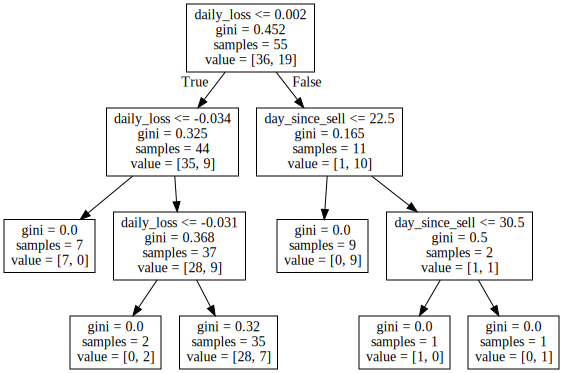

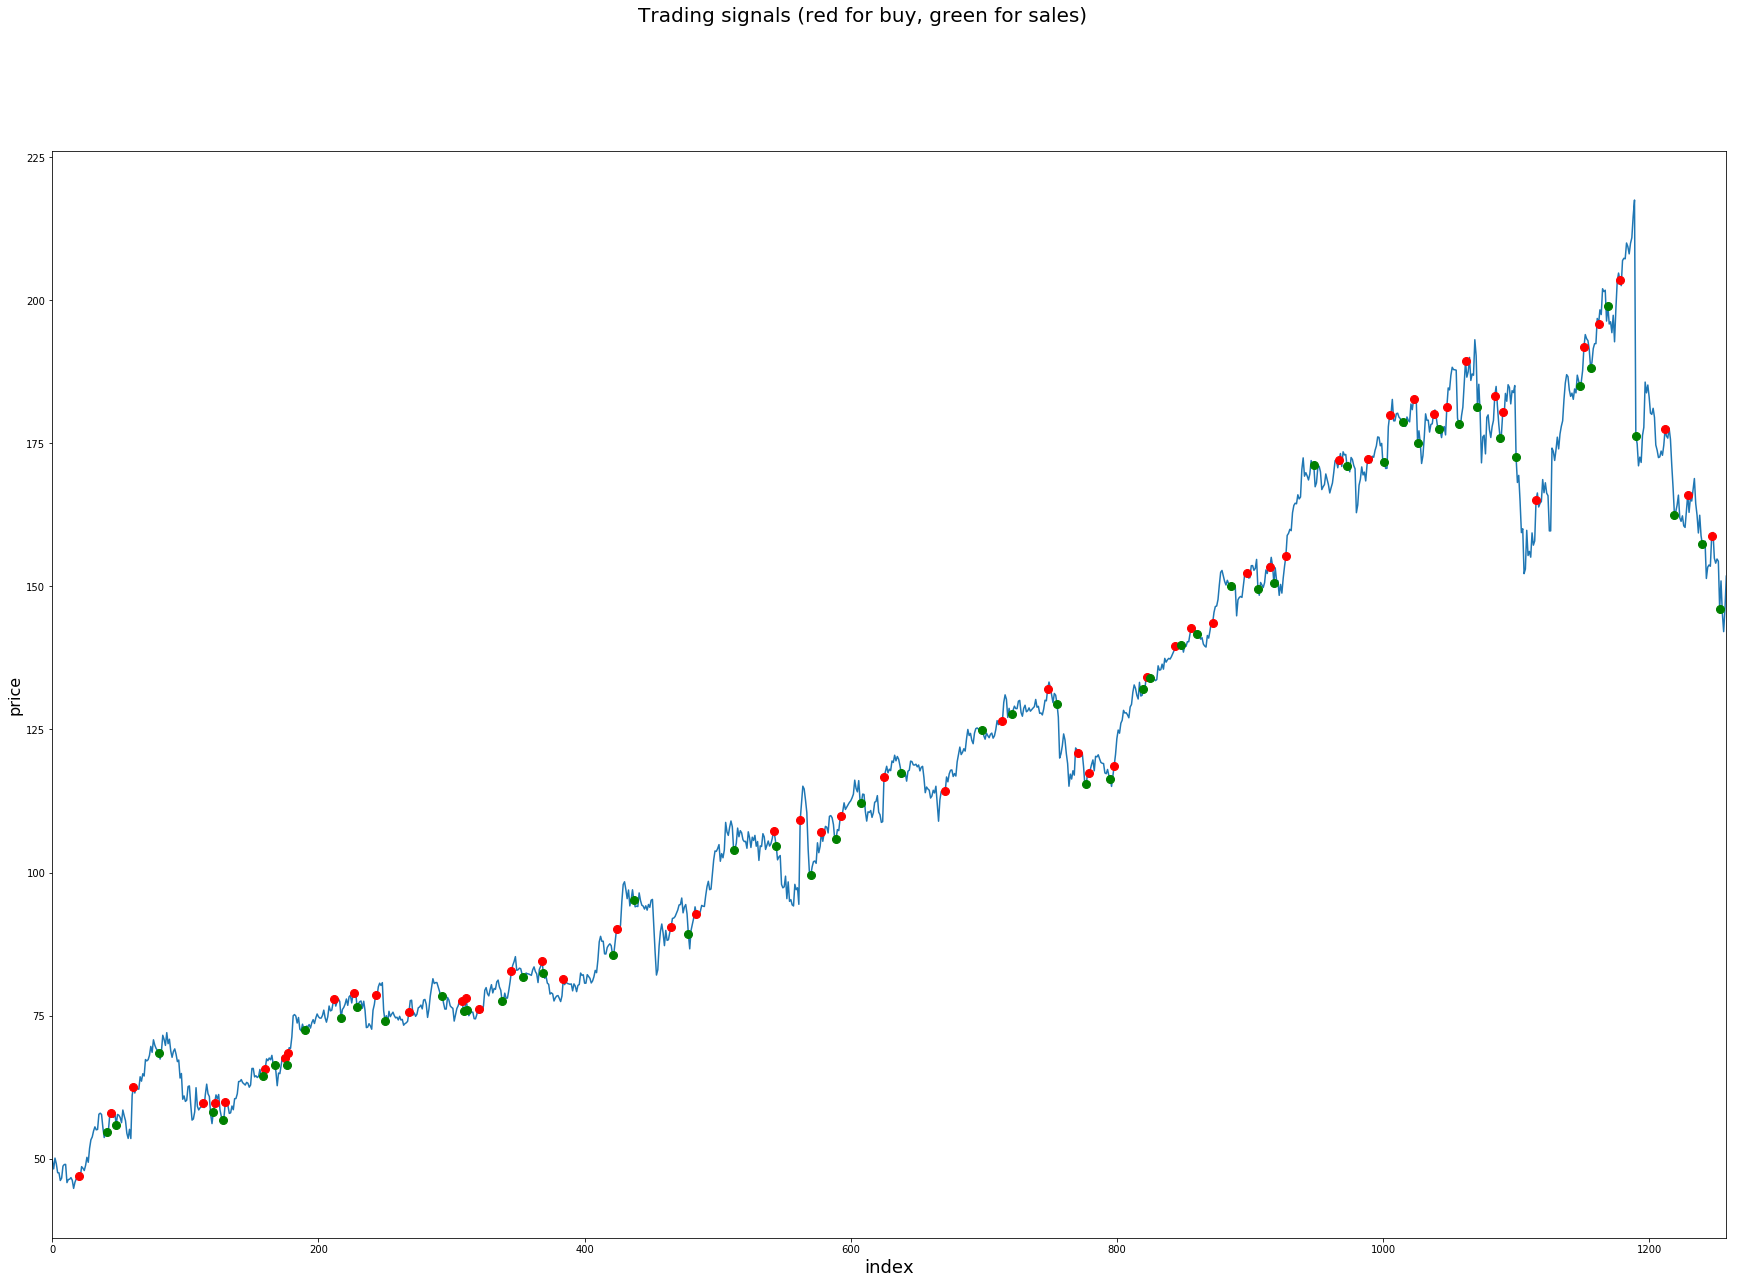

In [184]:
abbrev = 'FB'
df = pd.read_csv('Data/{}.csv'.format(abbrev))
close = df['Close']
low = df['Low']

#close = np.append(close,[288.67])
#close = pd.Series(close)
summary = get_rich(close,low)
summary.cart_graph

The natural ROI throughout the period is 2.0510551356783915,     total ROI if following every buy and sell signal is 0.0038917639780795543


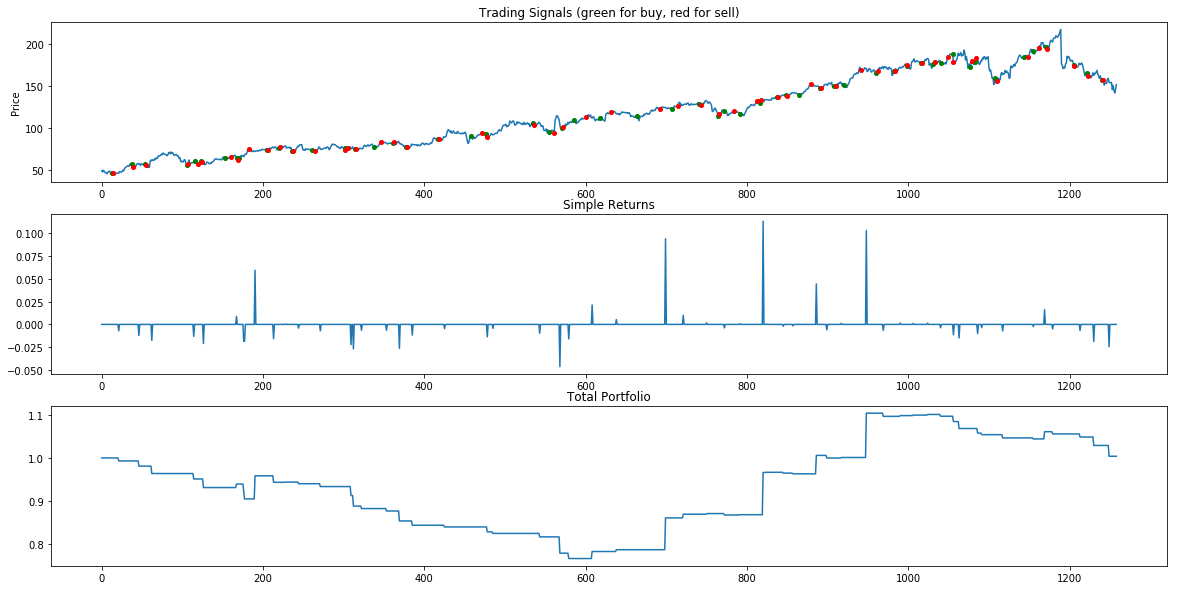

In [186]:
thresh__ = 0.002
#thresh__ = -0.011
res = run_strategy(close = close, strategy_func=macd_with_stop,thresh = thresh__,strategy_name='MACD Stop')

In [188]:
res.latest_position

'waiting'

In [189]:
res.recent_bought

158.779999

In [201]:
macd_with_stop(149,close,thresh__,res.recent_bought,res.latest_position)

'buy'